In [1]:
import pathlib
# import json

# from attrs import define, field, evolve
# import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from odbex.py3 import simdata

In [2]:
TEST_DATA = pathlib.Path('/home/michael_olaya_student_uml_edu/repos/odb-extractor/tests/raw_odbex/extracted_rimr_carbon_1fib_vf_0p55_RI_fbc_16cpu_22.json')

In [4]:
sd = simdata.SimulationData.from_extracted(TEST_DATA)
stress = sd.get_region_data('pull-step', 'SET-ALLELEMENTS').volume_average_field('S')
strain = sd.get_region_data('pull-step', 'SET-ALLELEMENTS').volume_average_field('E')

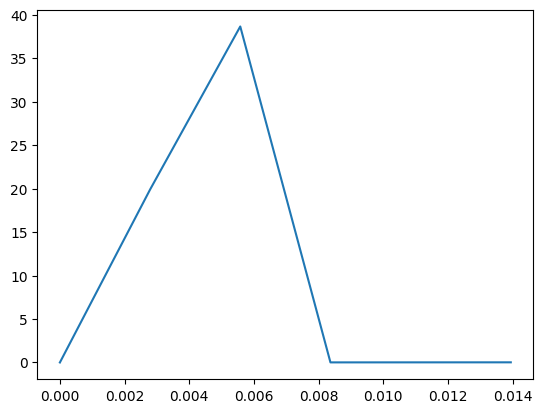

In [5]:
fig, ax = plt.subplots()
ax.plot(strain.data[:, 1], stress.data[:, 1])